In [1]:
import sys
import matplotlib.pyplot as plt
import importlib
data_dir = "Saved_networks/"
import tango_model as tango_model
importlib.reload(sys.modules['tango_model'])
from tango_model import *
import scipy as sp
from scipy.stats import nbinom
import torch
import networkx as nx
import pandas as pd
import os
from PIL import Image
import seaborn as sns
from datetime import date

In [2]:
# Parameters (make sure these match the ones used during export)
N = 170000
ub = 300  # Adjust if needed

# Load network data
network_data = np.loadtxt(data_dir + f'Network_N={N:.1e}_ub={ub}.csv', delimiter=',', skiprows=1)
rows = torch.tensor(network_data[:, 0], dtype=torch.int32)
cols = torch.tensor(network_data[:, 1], dtype=torch.int32)
strengths = torch.tensor(network_data[:, 2], dtype=torch.int32)

# Reconstruct indices by repeating edges according to strengths
indices_rows = rows.repeat_interleave(strengths)
indices_cols = cols.repeat_interleave(strengths)
indices = torch.stack([indices_rows, indices_cols])

# Load member data
member_data = np.loadtxt(data_dir + f'Member_data_N={N:.1e}_ub={ub}.csv', delimiter=',', skiprows=1)
# Columns: seeking, r_new, r_old, tot_enc, tot_par
seeking = torch.tensor(member_data[:, 0], dtype=torch.uint8)
r_new = torch.tensor(member_data[:, 1], dtype=torch.float32)
r_old = torch.tensor(member_data[:, 2], dtype=torch.float32)
# tot_enc and tot_par are not needed for the simulation state

# Load tot_log data
tot_log_data = np.loadtxt(data_dir + f'tot_log_N={N:.1e}_ub={ub}.csv', delimiter=',', skiprows=1)
log_rows = torch.tensor(tot_log_data[:, 0], dtype=torch.int32)
log_cols = torch.tensor(tot_log_data[:, 1], dtype=torch.int32)
log_t = torch.tensor(tot_log_data[:, 2], dtype=torch.int32)
repeats = torch.tensor(tot_log_data[:, 3], dtype=torch.int32)

# Reconstruct tot_log by expanding repeats
expanded_rows = log_rows.repeat_interleave(repeats)
expanded_cols = log_cols.repeat_interleave(repeats)
expanded_t = log_t.repeat_interleave(repeats)
tot_log = torch.stack([expanded_rows, expanded_cols, expanded_t])

In [3]:
M           = 28
r_old_mean  = 0.2
pexp        = 1.55
lb          = 0.15
window      = 365
old_dist    = "gamma"
alpha       = 2
Tmax        = 120

# Initialize the simulation object
simulation = EpidemicSimulation(N,M,r_old_mean,pexp,old_dist,alpha,ub,lb)

# Load the state into the simulation
if M == 0:
    indices = torch.tensor([[],[]])
simulation.load_state(
    indices=indices,
    seeking=seeking,
    r_new=r_new,
    r_old=r_old,
    tot_log=tot_log,
    t=simulation.t  # You can set this to the appropriate time if needed
)

# Or to start the war-time simulation:
p               = 0.48
TE              = 5
n               = 2
pre_vac         = 0.13
n_seed          = 10 #Number of initial imported cases

import_date = date(2022, 5, 19)

# Input parameters
end_date = date(2022, 9, 1) #End of behavior change
t0_date = date(2022, 7, 6) #Date of maximum decrease (fitted)
k = 2.5/30.5 #Fitted and converted from month to day

name        = "Counterfactual"  ###### !!!!!!! #######
if name == "Counterfactual":
    TI_changes  = None
    TI0         = 18
else:
    # Generate sigmoid values
    TSvals      = generate_sigmoid_values(import_date, end_date, t0_date, k)
    TSvals      = np.array([val[1] for val in TSvals])
    TIvals      = 2*(TSvals - TE)
    TI0         = TIvals[0]
    TI_changes  = torch.tensor([np.arange(1,len(TIvals)),TIvals[1:]])

simulation.initialize_war_time(
    TE=TE,
    TI=TI0,
    n=n,
    p=p,
    TI_changes=TI_changes,
)
simulation.iterate_war_time(n_seed=n_seed,Tmax=Tmax)

 Run: 0, t: 119, I: 0.90%, R: 1.09% (including inactive), TI = 18.00 days, p = 0.48

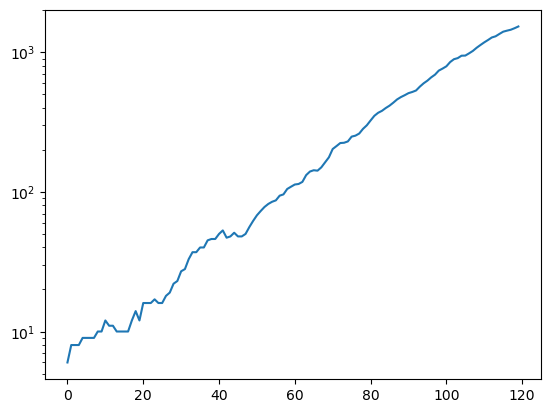

In [4]:
plt.plot(simulation.I)
plt.yscale("log")

In [5]:
color_palette = ["#3d348b","#7678ed","#f7b801","#f18701","#f35b04"]

In [6]:
mask = (simulation.infection_times > 0) & (simulation.infection_times < 60) # Exclude imports and only count people infected in exponential phase
num_in_data = mask.sum() # Number of infected in period
mu = simulation.secondary_infs[mask].float().mean()
mu
var = simulation.secondary_infs[mask].float().var()

# Dispersion parameter k for negative binomial: k = mu**2 / (var - mu)
dispersion_k = mu**2 / (var - mu)
print(f"Dispersion parameter: {dispersion_k:.2f}")
print(f"R0: {mu:.2f}")

Dispersion parameter: 0.63
R0: 1.97


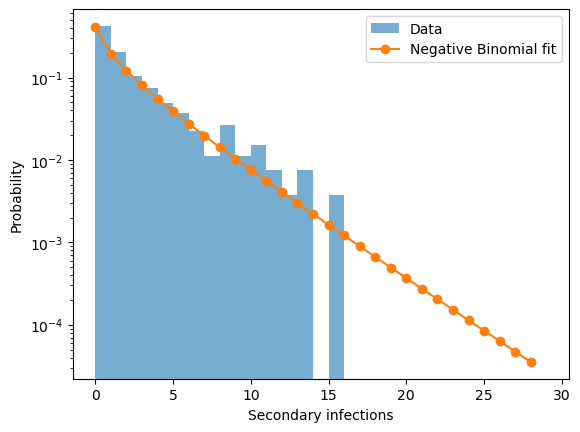

In [7]:
# Calculate negative binomial parameters from mu and var
mu_val = float(mu)
var_val = float(var)
p_nb = mu_val / var_val
n_nb = mu_val * p_nb / (1 - p_nb)

# Plot histogram of data
plt.hist(simulation.secondary_infs[mask].cpu().numpy(), bins=np.arange(30), density=True, alpha=0.6, label='Data')

# Plot negative binomial PMF
x = np.arange(0, 29)
pmf = nbinom.pmf(x, n_nb, p_nb)
plt.plot(x, pmf, 'o-', label='Negative Binomial fit')

plt.yscale("log")
plt.xlabel('Secondary infections')
plt.ylabel('Probability')
plt.legend()
plt.show()

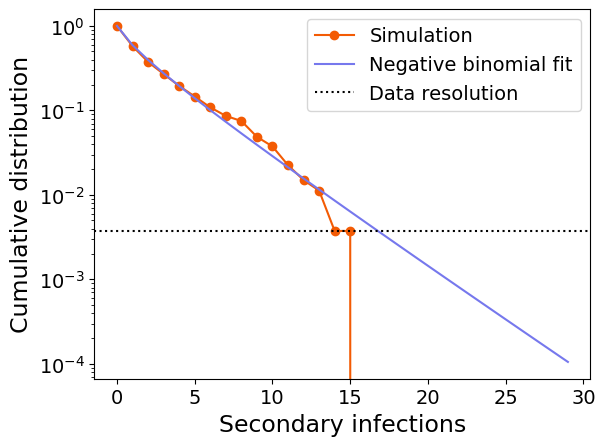

In [8]:
# Plot the complementary cumulative distribution function (CCDF)
data = simulation.secondary_infs[mask].cpu().numpy()
counts, bin_edges = np.histogram(data, bins=np.arange(30), density=True)
x = np.arange(0,30)
# empirical
ccdf_data = [(data >= k).mean() for k in x]
nb_ccdf = 1 - nbinom.cdf(x-1, n_nb, p_nb)
plt.plot(x, ccdf_data,  marker='o',markersize = 6, label='Simulation',color = color_palette[-1])
plt.plot(x, nb_ccdf,    marker=None, label='Negative binomial fit',color = color_palette[1])
plt.axhline(1/num_in_data,label = "Data resolution",color = "k",ls = "dotted")
plt.yscale('log')
labelsize = 17
ticksize = 14
legendsize = 14
plt.xlabel('Secondary infections',fontsize = labelsize)
plt.ylabel('Cumulative distribution',fontsize = labelsize)
plt.xticks(fontsize = ticksize)
plt.yticks(fontsize = ticksize)
plt.legend(fontsize = legendsize)
plt.show()
#ccdf = 1 - np.cumsum(counts) * np.diff(bin_edges)

# plt.plot(bin_edges[1:], ccdf, marker='o', linestyle='-', label='Data CCDF')

# # Negative binomial CCDF
# plt.plot(x, nb_ccdf, 'o-', label='Negative Binomial fit CCDF')
# plt.ylim(1e-4,1)

# plt.yscale("log")
# plt.xlabel('Secondary infections')
# plt.ylabel('CCDF')
# plt.legend()
# plt.show()

In [9]:
np.unique(data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15],
      dtype=int16)

In [10]:
europe_pop = 744 #million
simulation.R[105]*62/europe_pop #Cases per million

tensor(84.3333)

(0.0, 20.0)

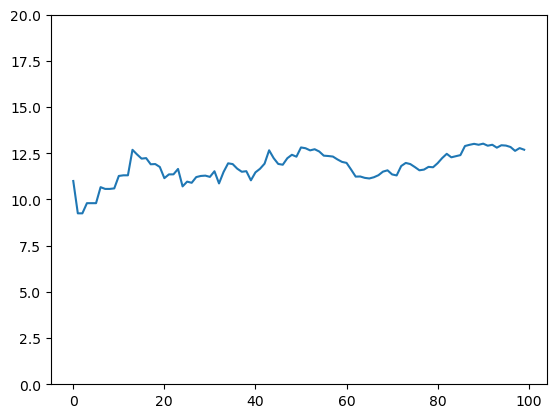

In [11]:
time_points, gen_time,ser_int = simulation.moving_window_gen_ser(window_size=10)
plt.plot(time_points[:-20],ser_int[:-20])
plt.ylim(0,20)

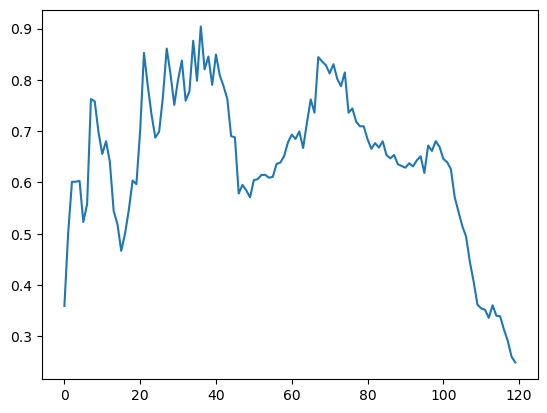

In [12]:
time_points, k_arr = simulation.moving_window_k(20)
plt.plot(time_points,k_arr)